# 笔记
## 1. 模型选择
- 训练数据集：训练模型参数
- 验证数据集：选择模型超参数 




- 训练误差：模型在训练数据上的误差
- 泛化误差：模型在新数据上的误差
 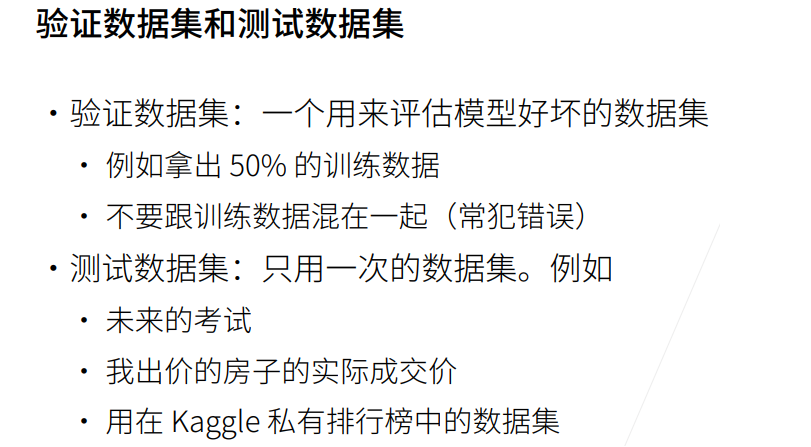
- 验证数据集不参与训练，所以可以反应超参数的好坏！
- 不能用测试集调参数啊！是用验证集调超参数。
- *但是，很多时候我们并不真正拥有测试数据集。所以很多时候test data其实是验证数据集。*

K-则交叉验证：
- 非大数据集上通常使用k-折交叉验证
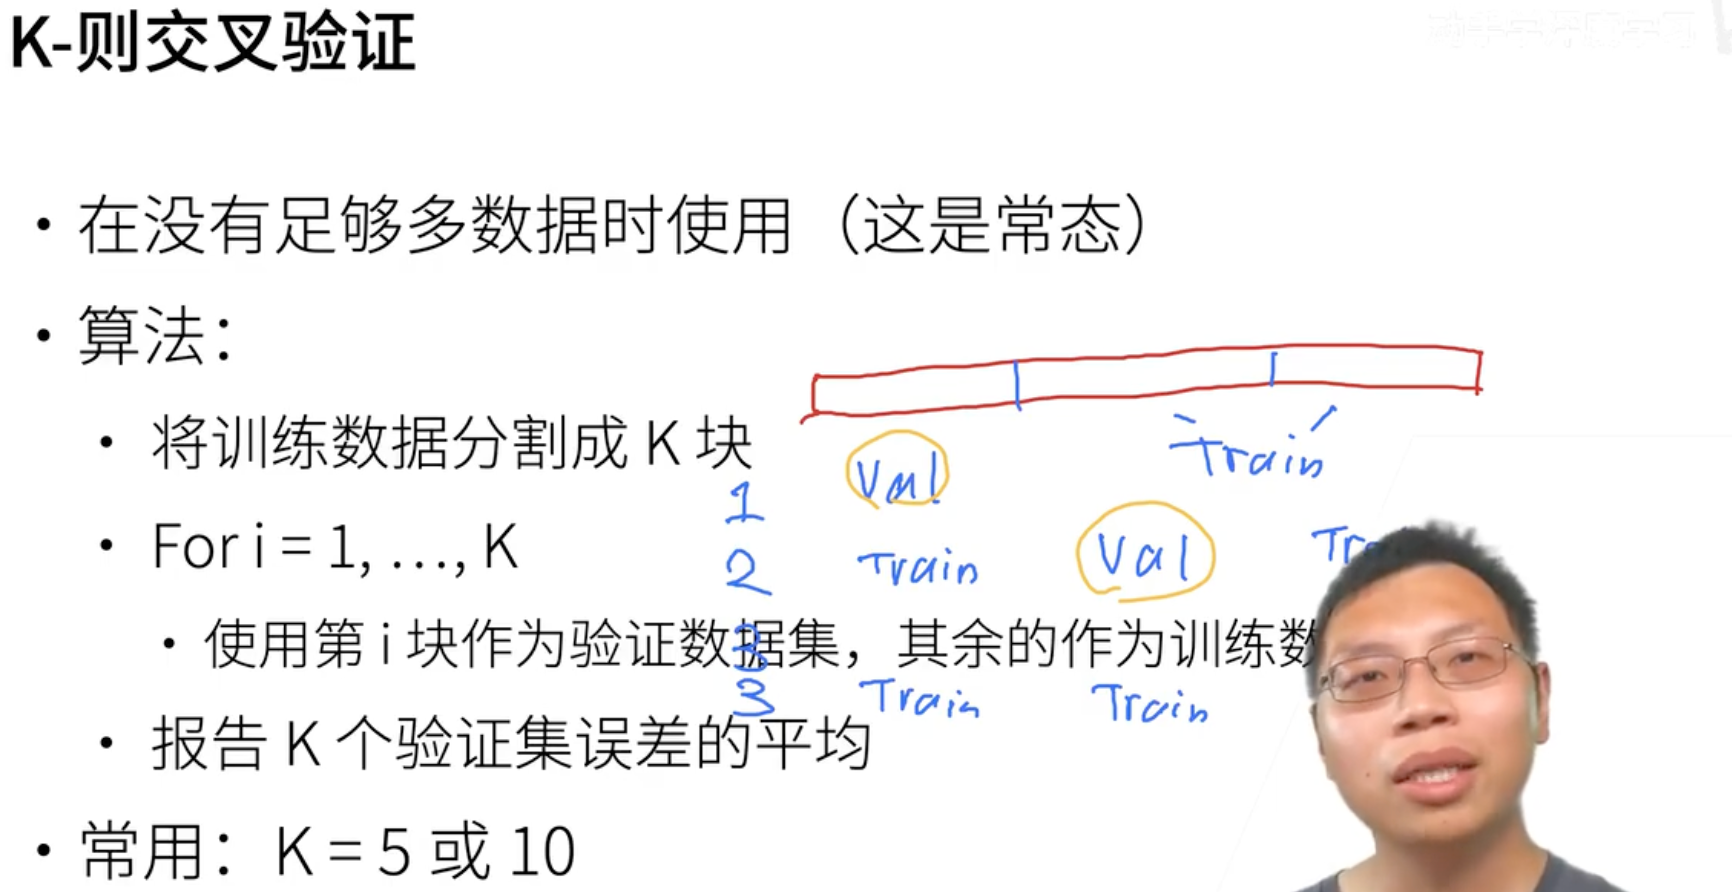

## 2. 过拟合和欠拟合

一个图说明：
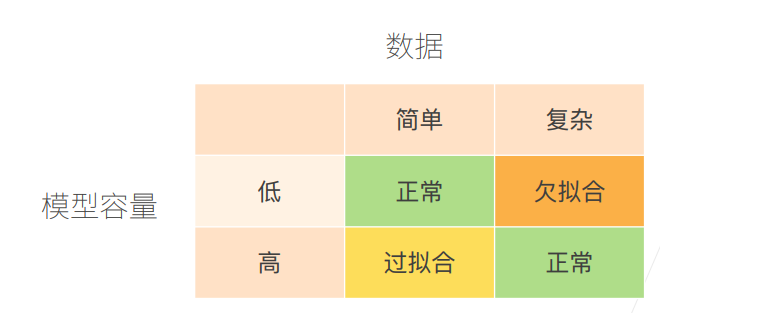
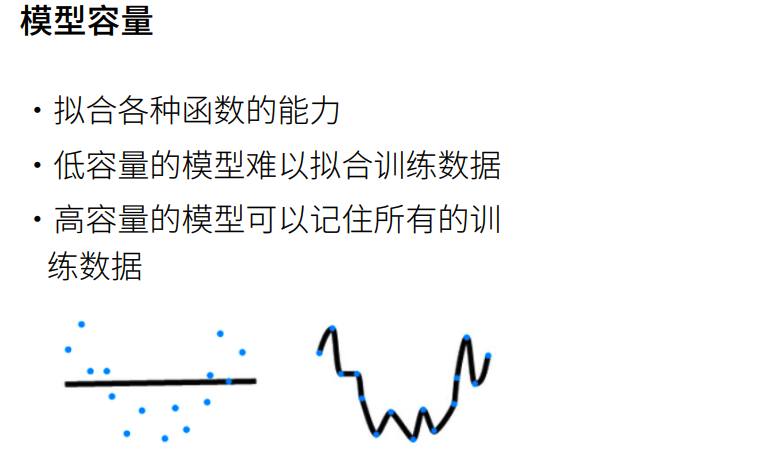

模型过于关心细节之后，会过拟合。一般是让模型足够大，然后再通过手段让模型容量往下降，从而减少泛化误差
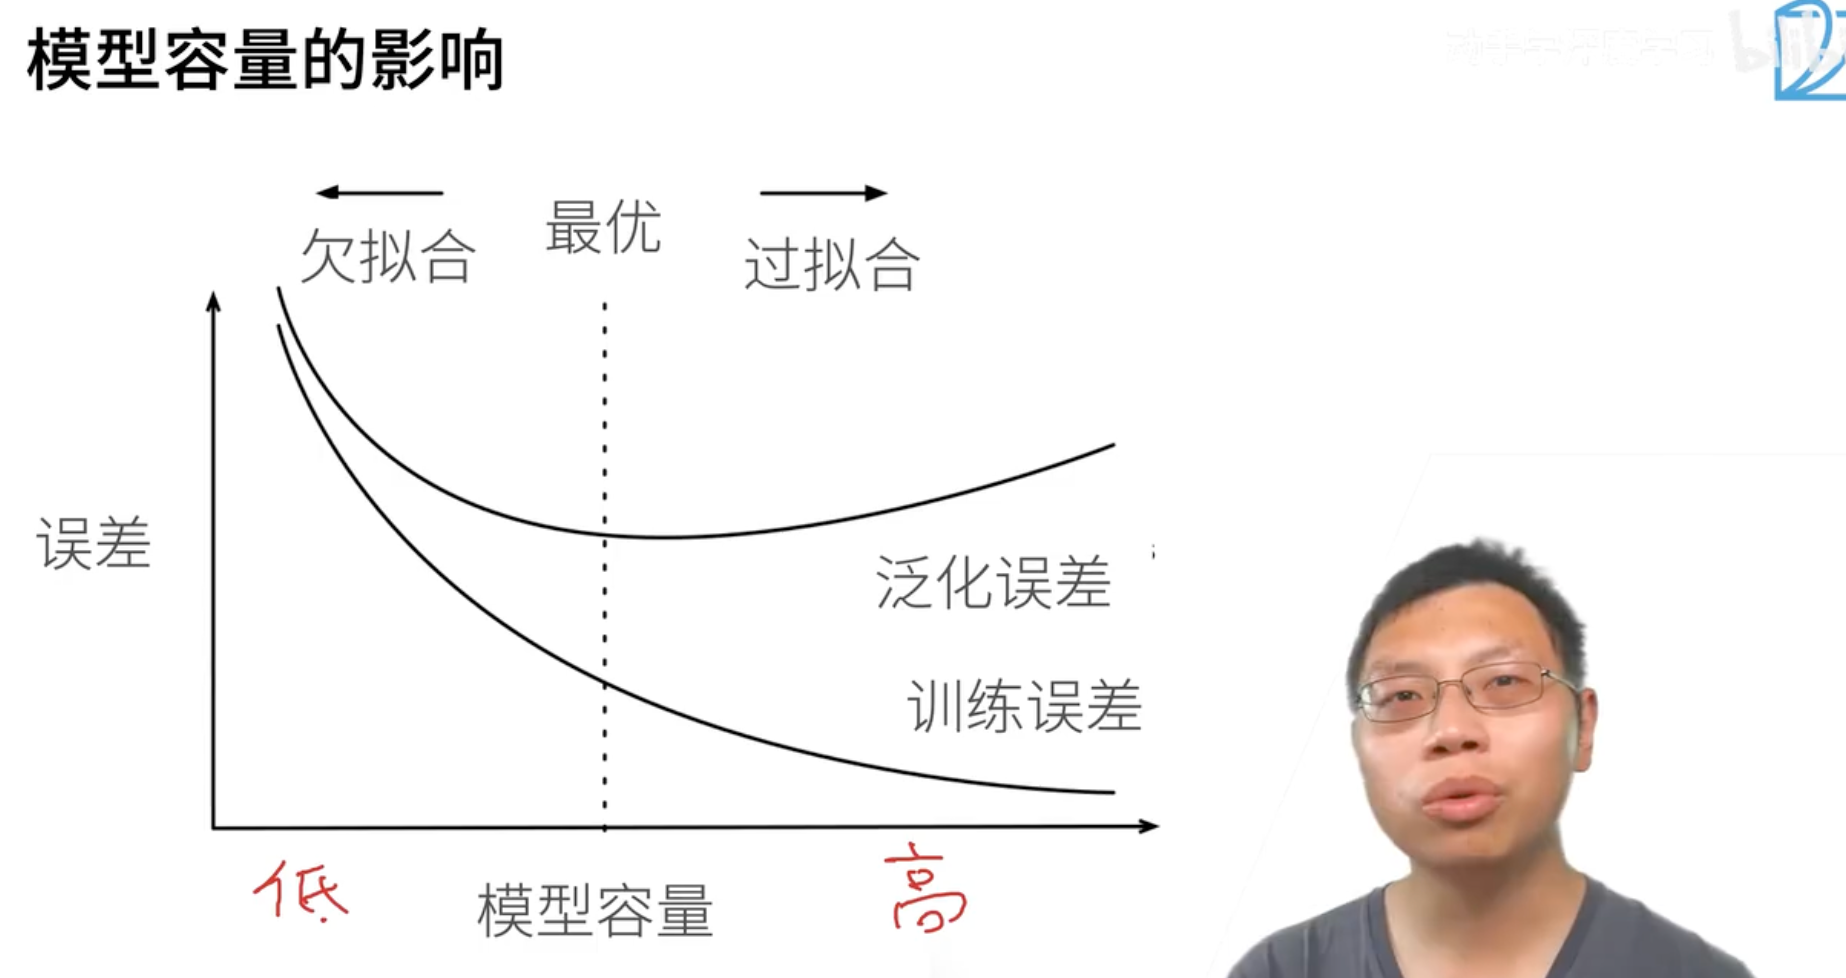
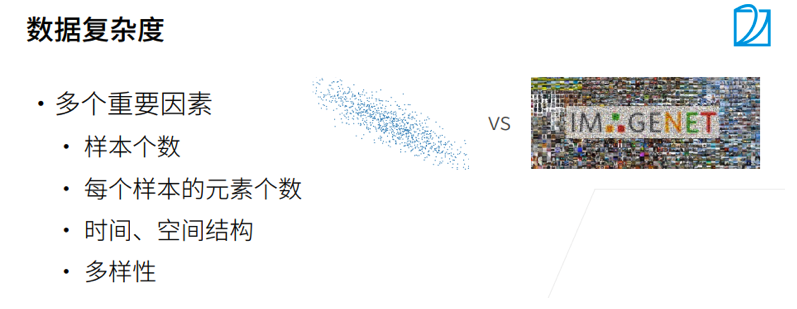

 # 代码
 - 以下代码将拟合多项式

In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [12]:
# 变量初始化
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
   ## 将该数组的前 4 个元素赋值为特定的值，意味着我们构造的多项式真实的系数情况是前面 4 项系数分别为给定的值，而从第 5 项系数开始（对应多项式更高次项）系数都默认为 0
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) 

# 特征数据生成，也就是输入x
features = np.random.normal(size=(n_train + n_test, 1)) 
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) #幂运算来构建多项式特征
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!

# 标签生成，也就是正确输出y
## labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [19]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

/var/folders/sn/bs172zhn025_0nwmmklh2nlm0000gn/T/ipykernel_10382/577943106.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_w, features, poly_features, labels = [torch.tensor(x, dtype=


In [22]:
# 模型评估
def evaluate_loss(net,data_iter,loss):
    metric=d2l.Accumulator(2) #(损失总和，样本数量)
    for X,y in data_iter:
        out=net(X)
        y=y.reshape(out.shape)
        l=loss(out,y)
        metric.add(l.sum(), l.numel())
    return metric[0]/metric[1]

# 训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

In [ ]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])